In [69]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

**Data Creation:**

In [103]:
CLASSES = 5
FEATURES = 2
RANDOM_SEED = 42

x, y = make_blobs(
    n_samples=6000,
    n_features=FEATURES,
    centers=CLASSES,  
    cluster_std=1.5, #noise
    random_state=RANDOM_SEED)

In [104]:
x=torch.from_numpy(x).type(torch.float)
y=torch.from_numpy(y).type(torch.LongTensor)

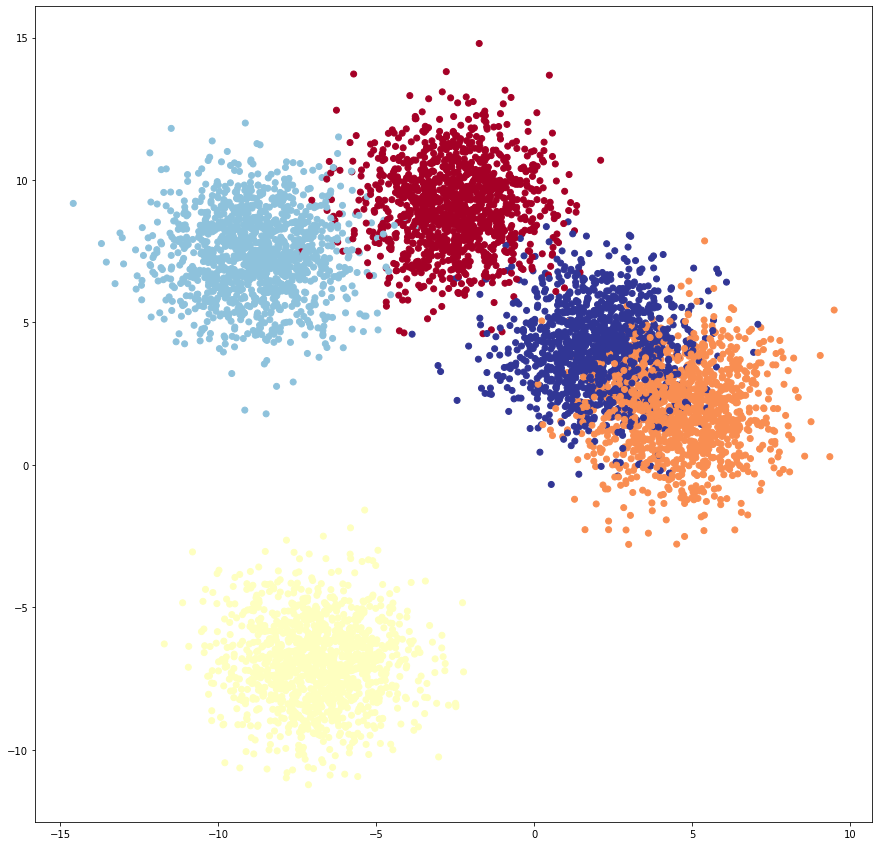

In [105]:
plt.figure(figsize=(15,15))
plt.scatter(x[:,0], x[:,1], c=y, cmap=plt.cm.RdYlBu)

In [106]:
x[:10], y[:10]

(tensor([[-5.7284, -6.8827],
         [ 3.5041,  4.8503],
         [ 3.5367,  1.8896],
         [ 5.8609,  2.1661],
         [-5.6568,  8.7903],
         [ 4.3445,  1.2763],
         [-9.3518,  8.6767],
         [ 1.5123,  7.0909],
         [ 1.4181,  3.9075],
         [-0.2830,  9.5477]]), tensor([2, 4, 4, 1, 3, 1, 3, 4, 4, 0]))

**Split:**

In [107]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=42)

**Model:**

In [127]:
class multiClassifier(nn.Module):
  def __init__(self, input, output, hidden_units=8):

    super().__init__()
  #Stacking layers through nn.Sequential

    self.layer_stack=nn.Sequential(
        nn.Linear(in_features=input, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=16),
        nn.Linear(in_features=16, out_features=output)
    )

  def forward(self, x):
    return self.layer_stack(x)


In [134]:
model1=multiClassifier(FEATURES,CLASSES).to(device)
model1

multiClassifier(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=5, bias=True)
  )
)

**loss function and optimizer:**

In [135]:
CELloss=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model1.parameters(), lr=0.1)

In [130]:
model1(x_train)[:10]

tensor([[-0.2850, -0.7317, -0.1563,  0.2599,  1.1472],
        [-0.4501, -0.1157,  0.3816, -0.3920,  0.5105],
        [-0.5800, -0.7413,  0.0287, -0.0997,  1.4386],
        [-0.3607, -0.9546, -0.2630,  0.3276,  1.5058],
        [-0.3013, -0.7353, -0.1483,  0.2423,  1.1673],
        [-0.2397, -0.4806, -0.0102,  0.1341,  0.7811],
        [-0.1266, -0.6281, -0.1868,  0.3815,  0.8641],
        [-0.0349, -0.5411, -0.1856,  0.4325,  0.6652],
        [-0.4024, -0.5669,  0.0352, -0.0055,  1.0461],
        [ 0.3826,  1.0615,  0.6633, -0.2113, -1.7927]],
       grad_fn=<SliceBackward0>)

**Train & test Loop**

In [131]:
from torchmetrics import Accuracy
metricAccuracy=Accuracy(task="multiclass", num_classes=CLASSES).to(device)

In [136]:

torch.manual_seed(42)

epochs=500

epoch_nums=[]
train_loss_vals=[]
test_loss_vals=[]

x_train, x_test, y_train, y_test = x_train.to(device), x_test.to(device), y_train.to(device), y_test.to(device)

for epoch in range(epochs):
  
  model1.train()
  rawtrain_pred=model1(x_train)
  ypred_train=torch.softmax(rawtrain_pred, dim=1).argmax(dim=1)

  train_loss=CELloss(rawtrain_pred, y_train)
  train_acc=metricAccuracy(ypred_train, y_train)

  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  model1.eval()
  with torch.inference_mode():
    rawtest_pred=model1(x_test)
    ypred=torch.softmax(rawtest_pred, dim=1).argmax(dim=1)

    test_loss=CELloss(rawtest_pred, y_test)
    test_acc=metricAccuracy(ypred,y_test)


  if epoch % 50 == 0:
    print(f"Epoch: {epoch}   Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}%    Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%")  


  epoch_nums.append(epoch)
  train_loss_vals.append(train_loss.detach().numpy())
  test_loss_vals.append(test_loss.detach().numpy())

Epoch: 0   Loss: 1.8290, Acc: 19.85%    Test Loss: 1.1938, Test Acc: 53.50%
Epoch: 50   Loss: 0.2067, Acc: 91.98%    Test Loss: 0.1833, Test Acc: 94.50%
Epoch: 100   Loss: 0.2225, Acc: 91.10%    Test Loss: 0.1889, Test Acc: 92.25%
Epoch: 150   Loss: 0.1920, Acc: 92.10%    Test Loss: 0.1658, Test Acc: 94.25%
Epoch: 200   Loss: 0.1855, Acc: 92.35%    Test Loss: 0.1610, Test Acc: 94.08%
Epoch: 250   Loss: 0.1816, Acc: 92.60%    Test Loss: 0.1581, Test Acc: 93.50%
Epoch: 300   Loss: 0.1774, Acc: 92.75%    Test Loss: 0.1543, Test Acc: 93.58%
Epoch: 350   Loss: 0.1732, Acc: 92.81%    Test Loss: 0.1504, Test Acc: 94.08%
Epoch: 400   Loss: 0.1695, Acc: 92.96%    Test Loss: 0.1471, Test Acc: 94.25%
Epoch: 450   Loss: 0.1662, Acc: 93.10%    Test Loss: 0.1442, Test Acc: 94.50%


**Loss Plot:**

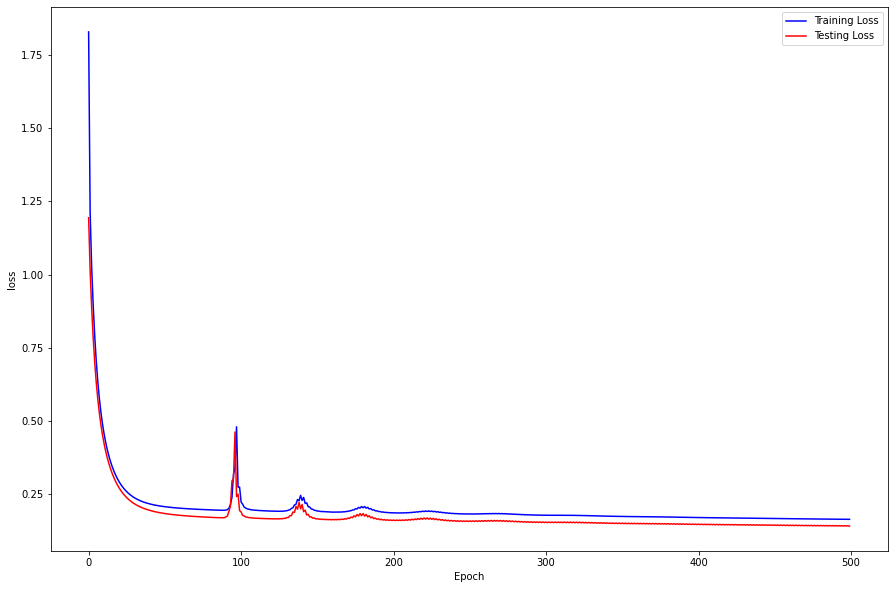

In [137]:
plt.figure(figsize=(15,10))
plt.plot(epoch_nums, train_loss_vals, c="b", label="Training Loss")
plt.plot(epoch_nums, test_loss_vals, c="r", label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()

**Decision Boundary Plot:**

In [138]:
import numpy as np
def plot_decision_boundary(model, X, y):

    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

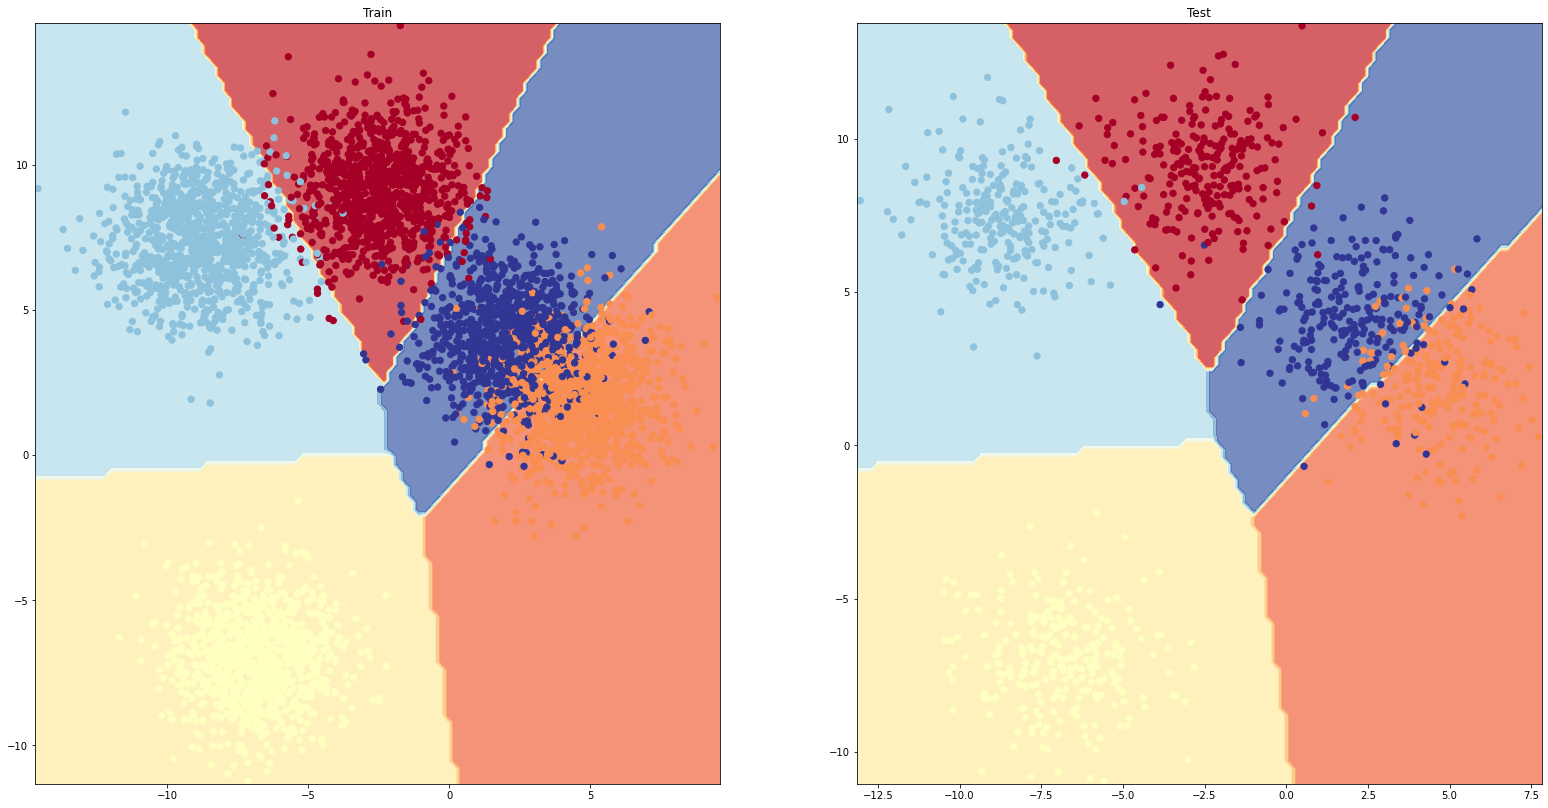

In [139]:
plt.figure(figsize=(27, 14))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model1, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model1, x_test, y_test)